In [1]:
import requests
from io import StringIO
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

plt.ioff()

# import requests
def get_candles(symbol):
    params = {
        "symbol": symbol,
        "resolution": 1,
        "from": 1562185565,
        "to": 1593807965,
        "format": "csv",
        "token": "brvj9rvrh5rd378r2s70"

    }
    r = requests.get('https://finnhub.io/api/v1/stock/candle', params)
    df = pd.read_csv(StringIO(r.text), index_col="t")
    return df
df = get_candles("AMD")

o      h      l      c      v
t                                                     
2020-06-22 12:01:00  54.20  54.20  54.20  54.20  400.0
2020-06-22 12:08:00  54.20  54.20  54.20  54.20  372.0
2020-06-22 12:20:00  54.20  54.20  54.20  54.20  115.0
2020-06-22 12:37:00  54.25  54.26  54.25  54.26  700.0
2020-06-22 12:38:00  54.26  54.26  54.26  54.26  250.0
...                    ...    ...    ...    ...    ...
2020-07-02 23:52:00  52.32  52.32  52.32  52.32    0.0
2020-07-02 23:53:00  52.31  52.31  52.31  52.31    0.0
2020-07-02 23:55:00  52.31  52.31  52.31  52.31    0.0
2020-07-02 23:58:00  52.29  52.29  52.29  52.29    0.0
2020-07-02 23:59:00  52.28  52.28  52.28  52.28    0.0

[6297 rows x 5 columns]


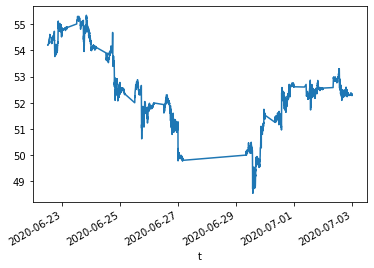

In [4]:
df.index = pd.to_datetime(df.index, unit="s")
print(df)
df["c"].plot()

plt.show()